#<center> Marathon AI 2021



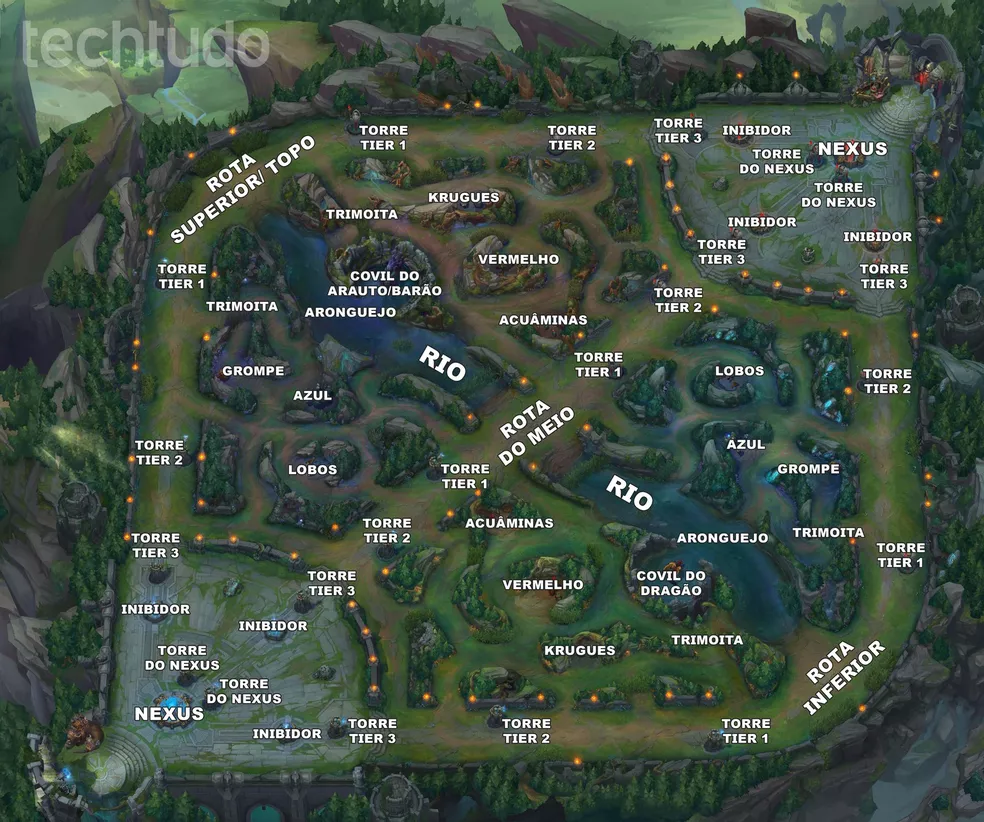

League of Legends (LoL) é um jogo eletrônico online gratuito, do gênero batalha multijogador.
No LoL, os jogadores assumem o papel de "invocadores", que controlam campeões com habilidades únicas formando um time para lutarem contra o time adversário de outros invocadores/controlados pelo computador. No modo mais popular do jogo, o objetivo de cada time é destruir o Nexus da equipe adversária, uma construção localizada na base e protegida por outras estruturas (conforme foto acima).

Após essa breve introdução ao LoL, vamos então para o nosso desafio.

Imagine que sua equipe de desenvolvimento recebeu um dataset com o resultado de algumas partidas de LoL e lhes foi requisitado a analise dos dados, criação de um modelo de classificação para prever a vitória ou a derrota de um time e um relatório sobre os dados e requisitos.
No relatório deve conter: analise dos dados, modelo e matriz de confusão.

	Utilizando os conhecimentos adquiridos durante as aulas, sua equipe deverá fazer uma análise completa dos dados. No relatório deverá ser explicado e demonstrado conhecimentos adquiridos com os dados, mostrar anomalias, erros se existir e ainda explicar a escolha do modelo.


Algumas dicas:
    • Dataset: contém dados de aproximadamente 25000 jogos ranqueados (SOLO QUEUE) do Elo platina.
    • Cada jogo tem feature de diferentes time. Frames a partir dos 10 minutos até o fim do jogo (Por exemplo, game 1 10min, game1 12 min, game1 14min etc).
    • No total há mais de 240000 frames.
    • Existem 55 features coletadas do time azul/vermelho, isso inclui: abates, mortes, ouro, experiência, nível. Cabe a equie realizar o feature engineering para obter mais insights.
    • A coluna "hasWon" é o valor target, se você está fazendo um problema de classificação como resultado.
    • Atributos que começam com is* são boleanos (0 ou 1).

## Carregar os dados

In [ ]:
# importar módulos exigidos
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ler o dataset usando a compressão zip
df = pd.read_csv(
    'https://github.com/JessicaSousa/DesafioHackathon/raw/master/lol_ranked_games_red.zip',
    compression='zip'
)

# exibir informações do dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242572 entries, 0 to 242571
Data columns (total 59 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameId                   242572 non-null  int64  
 1   gameDuration             242572 non-null  int64  
 2   hasWon                   242572 non-null  int64  
 3   frame                    242572 non-null  int64  
 4   goldDiff                 242572 non-null  int64  
 5   expDiff                  242572 non-null  int64  
 6   champLevelDiff           242572 non-null  float64
 7   isFirstTower             242572 non-null  int64  
 8   isFirstBlood             242572 non-null  int64  
 9   killedFireDrake          242572 non-null  int64  
 10  killedWaterDrake         242572 non-null  int64  
 11  killedAirDrake           242572 non-null  int64  
 12  killedEarthDrake         242572 non-null  int64  
 13  killedElderDrake         242572 non-null  int64  
 14  lost

O dataset possui 242.572 registros e 59 colunas sem valores faltantes, a maioria das colunas possui dados do tipo inteiro com exceção de `champLevelDiff` que armazena valores do tipo real.

In [ ]:
df.head()

,gameId,gameDuration,hasWon,frame,goldDiff,expDiff,champLevelDiff,isFirstTower,isFirstBlood,killedFireDrake,killedWaterDrake,killedAirDrake,killedEarthDrake,killedElderDrake,lostFireDrake,lostWaterDrake,lostAirDrake,lostEarthDrake,lostElderDrake,killedBaronNashor,lostBaronNashor,killedRiftHerald,lostRiftHerald,destroyedTopInhibitor,destroyedMidInhibitor,destroyedBotInhibitor,lostTopInhibitor,lostMidInhibitor,lostBotInhibitor,destroyedTopNexusTurret,destroyedMidNexusTurret,destroyedBotNexusTurret,lostTopNexusTurret,lostMidNexusTurret,lostBotNexusTurret,destroyedTopBaseTurret,destroyedMidBaseTurret,destroyedBotBaseTurret,lostTopBaseTurret,lostMidBaseTurret,lostBotBaseTurret,destroyedTopInnerTurret,destroyedMidInnerTurret,destroyedBotInnerTurret,lostTopInnerTurret,lostMidInnerTurret,lostBotInnerTurret,destroyedTopOuterTurret,destroyedMidOuterTurret,destroyedBotOuterTurret,lostTopOuterTurret,lostMidOuterTurret,lostBotOuterTurret,kills,deaths,assists,wardsPlaced,wardsDestroyed,wardsLost
0,4546233126,1443000,0,10,448,147,0.2,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,7,5,21,3,5
1,4546233126,1443000,0,12,1306,925,0.6,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,11,6,28,4,6
2,4546233126,1443000,0,14,-2115,-2578,-0.4,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,10,11,12,35,4,6
3,4546233126,1443000,0,16,-1195,-2134,-0.4,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,10,12,12,45,6,10
4,4546233126,1443000,0,18,-2931,-4382,-0.6,1,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,13,13,16,49,7,12


In [ ]:
df.tail()

,gameId,gameDuration,hasWon,frame,goldDiff,expDiff,champLevelDiff,isFirstTower,isFirstBlood,killedFireDrake,killedWaterDrake,killedAirDrake,killedEarthDrake,killedElderDrake,lostFireDrake,lostWaterDrake,lostAirDrake,lostEarthDrake,lostElderDrake,killedBaronNashor,lostBaronNashor,killedRiftHerald,lostRiftHerald,destroyedTopInhibitor,destroyedMidInhibitor,destroyedBotInhibitor,lostTopInhibitor,lostMidInhibitor,lostBotInhibitor,destroyedTopNexusTurret,destroyedMidNexusTurret,destroyedBotNexusTurret,lostTopNexusTurret,lostMidNexusTurret,lostBotNexusTurret,destroyedTopBaseTurret,destroyedMidBaseTurret,destroyedBotBaseTurret,lostTopBaseTurret,lostMidBaseTurret,lostBotBaseTurret,destroyedTopInnerTurret,destroyedMidInnerTurret,destroyedBotInnerTurret,lostTopInnerTurret,lostMidInnerTurret,lostBotInnerTurret,destroyedTopOuterTurret,destroyedMidOuterTurret,destroyedBotOuterTurret,lostTopOuterTurret,lostMidOuterTurret,lostBotOuterTurret,kills,deaths,assists,wardsPlaced,wardsDestroyed,wardsLost
242567,4402156483,1774000,1,30,8523,13498,1.6,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,33,41,50,80,18,17
242568,4379826739,1013000,1,10,271,1243,0.2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,5,6,18,1,2
242569,4379826739,1013000,1,12,2013,3493,0.8,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,8,6,23,1,5
242570,4379826739,1013000,1,14,2388,4543,0.8,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,13,9,27,5,6
242571,4379826739,1013000,1,16,5601,7595,1.2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,17,10,31,6,10


Desejamos saber quais características importam para saber se uma partida foi ganha ou não, algumas colunas que podem ser candidatas a serem removidas são `gameId` nos informa apenas de qual partida foram retiradas as observações, a informação `frame` nos diz de qual frame as estatísticas foram retiradas. Além disso a coluna `hasWon` pode ser usada para dizer se uma partida foi ganha ou não.

## Exploração dos dados

Para a tarefa de classificação precisamos desconsiderar colunas que podem influenciar o modelo negativamente. Algumas hipóteses que desejamos verificar:

- Existência de colunas populadas com apenas um valor
- Colunas onde os valores sejam únicos por amostra. Nesse caso já podemos desconsiderar a coluna `gameId` que serve apenas para informar o ID do jogo.


In [ ]:
df.describe()

,gameId,gameDuration,hasWon,frame,goldDiff,expDiff,champLevelDiff,isFirstTower,isFirstBlood,killedFireDrake,killedWaterDrake,killedAirDrake,killedEarthDrake,killedElderDrake,lostFireDrake,lostWaterDrake,lostAirDrake,lostEarthDrake,lostElderDrake,killedBaronNashor,lostBaronNashor,killedRiftHerald,lostRiftHerald,destroyedTopInhibitor,destroyedMidInhibitor,destroyedBotInhibitor,lostTopInhibitor,lostMidInhibitor,lostBotInhibitor,destroyedTopNexusTurret,destroyedMidNexusTurret,destroyedBotNexusTurret,lostTopNexusTurret,lostMidNexusTurret,lostBotNexusTurret,destroyedTopBaseTurret,destroyedMidBaseTurret,destroyedBotBaseTurret,lostTopBaseTurret,lostMidBaseTurret,lostBotBaseTurret,destroyedTopInnerTurret,destroyedMidInnerTurret,destroyedBotInnerTurret,lostTopInnerTurret,lostMidInnerTurret,lostBotInnerTurret,destroyedTopOuterTurret,destroyedMidOuterTurret,destroyedBotOuterTurret,lostTopOuterTurret,lostMidOuterTurret,lostBotOuterTurret,kills,deaths,assists,wardsPlaced,wardsDestroyed,wardsLost
count,2.425720e+05,2.425720e+05,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.0,242572.0,242572.000000,242572.0,242572.0,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000,242572.000000
mean,4.501480e+09,1.785494e+06,0.501872,19.811264,11.413811,215.019351,0.026517,0.617709,0.998627,0.295908,0.300241,0.301943,0.303609,0.005545,0.295908,0.300241,0.301943,0.303609,0.005545,0.141274,0.141274,0.564319,0.564319,0.021977,0.030045,0.087689,0.021977,0.030045,0.087689,0.032184,0.038747,0.101656,0.032184,0.038747,0.101656,0.0,0.0,0.052005,0.0,0.0,0.052005,0.120624,0.117305,0.193027,0.120624,0.117305,0.193027,0.379487,0.381870,0.369997,0.379487,0.381870,0.369997,16.391381,16.342220,21.166029,56.833530,10.487031,10.263077
std,5.331693e+07,3.761901e+05,0.499998,7.197339,5438.051920,5261.880802,0.772366,0.485948,0.037026,0.509759,0.515638,0.515935,0.519595,0.078099,0.509759,0.515638,0.515935,0.519595,0.078099,0.388436,0.388436,0.665504,0.665504,0.154788,0.179837,0.313325,0.154788,0.179837,0.313325,0.176490,0.192992,0.302197,0.176490,0.192992,0.302197,0.0,0.0,0.284509,0.0,0.0,0.284509,0.325690,0.321784,0.394675,0.325690,0.321784,0.394675,0.485260,0.485846,0.482805,0.485260,0.485846,0.482805,9.660237,9.697602,16.055645,58.734777,8.713549,8.736323
min,4.357970e+09,5.490000e+05,0.000000,10.000000,-23432.000000,-43304.000000,-3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
25%,4.463051e+09,1.532000e+06,0.000000,14.000000,-3409.000000,-2772.000000,-0.400000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,9.000000,9.000000,25.000000,4.000000,4.000000
50%,4.529395e+09,1.774000e+06,1.000000,18.000000,-24.000000

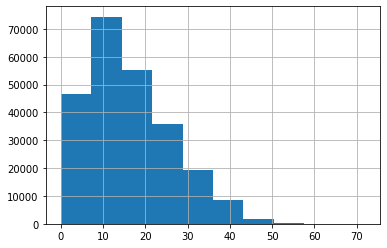

In [ ]:
df['deaths'].hist();

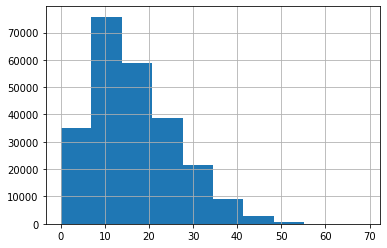

In [ ]:
df['kills'].hist();

In [ ]:
df['hasWon'].value_counts()

1    121740
0    120832
Name: hasWon, dtype: int64

- O conjunto de dados se encontra dividido em proporções aproximadas de quem ganhou e perdeu. 
- As variávéis `killedElderDrake`, `lostElderDrake`, 	`killedBaronNashor` e 	`lostBaronNashor` possuem 75\% dos valores com zero.
- As variáveis de `destroyedTopInhibitor` até `lostBotInnerTurret` também possuem 75\% do dataset preenchido com zero
- A distribuição de `kills` e `deaths` são similares
- As variáveis `destroyedTopBaseTurret`, `destroyedMidBaseTurret`, `lostMidBaseTurret` e `lostTopBaseTurret` estão preenchidas apenas com zeros e não agregam valor ao nosso conjunto




In [ ]:
# Remover colunas que não contribuem para a análise
df.drop(
    ['destroyedTopBaseTurret', 'destroyedMidBaseTurret', 'lostMidBaseTurret', 'lostTopBaseTurret'], 
    axis=1,
    inplace=True
)

Alguns pares de variáveis do tipo `destroy*`, `lost` e `killed` aparentam ter distribuição similares entre si, a seguir construímos uma função para obter a porcentagem dos grupos.

In [ ]:
def get_percentage(colname):
  counts = df[colname].value_counts()
  return pd.DataFrame({
      'percentage': (counts / counts.sum())*100
      })

In [ ]:
get_percentage('killedElderDrake')

,percentage
0,99.473558
1,0.499645
2,0.025559
3,0.001237


In [ ]:
get_percentage('lostElderDrake')

,percentage
0,99.473558
1,0.499645
2,0.025559
3,0.001237


In [ ]:
get_percentage('killedBaronNashor')

,percentage
0,87.279653
1,11.383424
2,1.268077
3,0.067609
4,0.001237


In [ ]:
get_percentage('lostBaronNashor')

,percentage
0,87.279653
1,11.383424
2,1.268077
3,0.067609
4,0.001237


Acima vemos que as variáveis `killed*` e `lost*` possuem distribuição idênticas.


In [ ]:
get_percentage('destroyedTopInhibitor')

,percentage
0,97.918144
1,1.973435
2,0.101001
3,0.007420


In [ ]:
get_percentage('lostTopInhibitor')

,percentage
0,97.918144
1,1.973435
2,0.101001
3,0.007420


In [ ]:
get_percentage('lostMidInhibitor')

,percentage
0,97.150537
1,2.699405
2,0.145112
3,0.004947


In [ ]:
get_percentage('destroyedMidInhibitor')

,percentage
0,97.150537
1,2.699405
2,0.145112
3,0.004947


Novamente vemos que as variáveis `destroyed*` e `lost*` possuem distribuição idênticas.

### Visualização 

Percebemos nas amostras acima que as colunas do tipo `killed` e `lost` possuem distribuições similares. Idem para as colunas `destroyed` e `lost`. Vamos verificar se a correspondência se mantém para todas as variáveis ao observar a correlação entre essas variáveis.

In [ ]:
df.columns[df.columns.str.startswith('killed')]

Index(['killedFireDrake', 'killedWaterDrake', 'killedAirDrake',
       'killedEarthDrake', 'killedElderDrake', 'killedBaronNashor',
       'killedRiftHerald'],
      dtype='object')

In [ ]:
df.columns[df.columns.str.startswith('destroyed')]

Index(['destroyedTopInhibitor', 'destroyedMidInhibitor',
       'destroyedBotInhibitor', 'destroyedTopNexusTurret',
       'destroyedMidNexusTurret', 'destroyedBotNexusTurret',
       'destroyedBotBaseTurret', 'destroyedTopInnerTurret',
       'destroyedMidInnerTurret', 'destroyedBotInnerTurret',
       'destroyedTopOuterTurret', 'destroyedMidOuterTurret',
       'destroyedBotOuterTurret'],
      dtype='object')

In [ ]:
df.columns[df.columns.str.startswith('lost')]

Index(['lostFireDrake', 'lostWaterDrake', 'lostAirDrake', 'lostEarthDrake',
       'lostElderDrake', 'lostBaronNashor', 'lostRiftHerald',
       'lostTopInhibitor', 'lostMidInhibitor', 'lostBotInhibitor',
       'lostTopNexusTurret', 'lostMidNexusTurret', 'lostBotNexusTurret',
       'lostBotBaseTurret', 'lostTopInnerTurret', 'lostMidInnerTurret',
       'lostBotInnerTurret', 'lostTopOuterTurret', 'lostMidOuterTurret',
       'lostBotOuterTurret'],
      dtype='object')

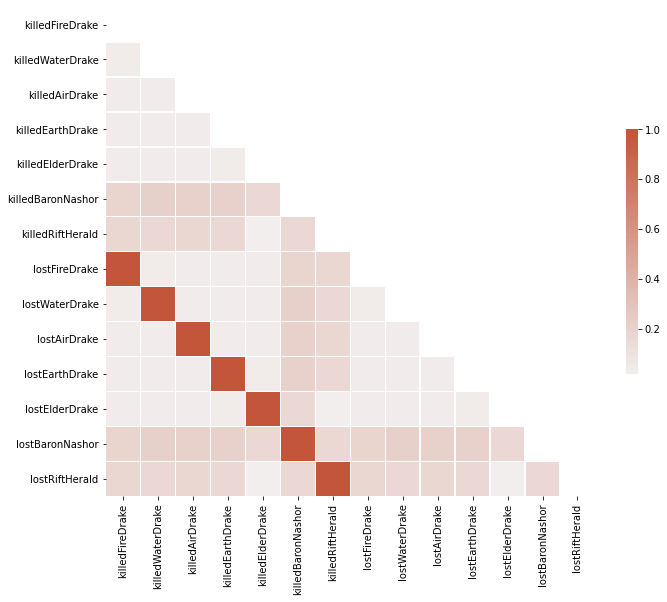

In [ ]:
# Selecionar as colunas de killed e apenas as lost que são equivalentes
selected_cols = df.columns[df.columns.str.startswith('killed')].tolist() + \
df.columns[df.columns.str.startswith('lost')].tolist()[:7]

# Obtém a correlação entre as coluna selecionadas
corr = df[selected_cols].corr()

# Gera uma máscara para o triângulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))


# Define uma figura do matplotlib
f, ax = plt.subplots(figsize=(11, 9))

# Gera um colormap divergente
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Desenha um heatmap com a máscara e o correto proporção
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

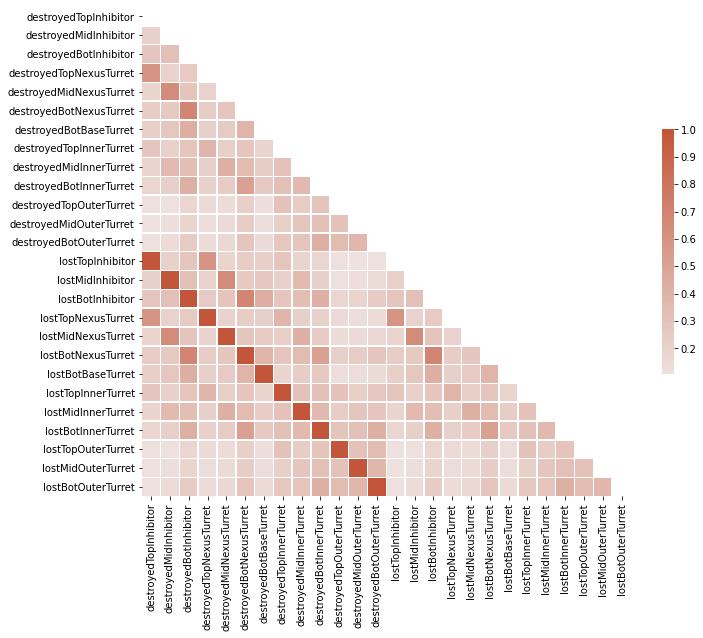

In [ ]:
selected_cols = df.columns[df.columns.str.startswith('destroyed')].tolist() + \
df.columns[df.columns.str.startswith('lost')].tolist()[7:]

# Obtém a correlação entre as coluna selecionadas
corr = df[selected_cols].corr()

# Gera uma máscara para o triângulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Define uma figura do matplotlib
f, ax = plt.subplots(figsize=(11, 9))

# Gera um colormap divergente
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Desenha um heatmap com a máscara e o correto proporção
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Confirmando nossas suspeitas, podemos notar nos gráficos que as variáveis do tipo `killed`, `destroyed` e `lost` possuem correlação com valor 1. No gráfico abaixo verificamos a correlação entre as variáveis do tipo `killed` com `destroyed`.

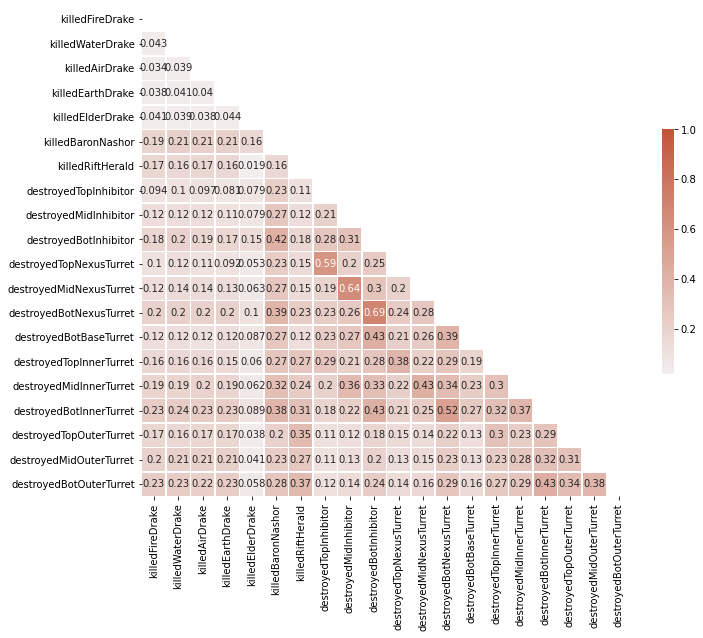

In [ ]:
selected_cols = df.columns[df.columns.str.startswith('killed')].tolist() + \
df.columns[df.columns.str.startswith('destroyed')].tolist()

# Obtém a correlação entre as coluna selecionadas
corr = df[selected_cols].corr()

# Gera uma máscara para o triângulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Define uma figura do matplotlib
f, ax = plt.subplots(figsize=(11, 9))

# Gera um colormap divergente
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Desenha um heatmap com a máscara e o correto proporção
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


Podemos notar no gráfico que as variáveis `destroyed*NexusTurret` e `destroyed*Inhibitor` possuem forte correlação (acima de 0.5) e `destroyedBotNextTurret` com `destroyedBotInnerTurret`. Para finalizar nossa análise, verificamos a correlação entre as variáveis restantes.

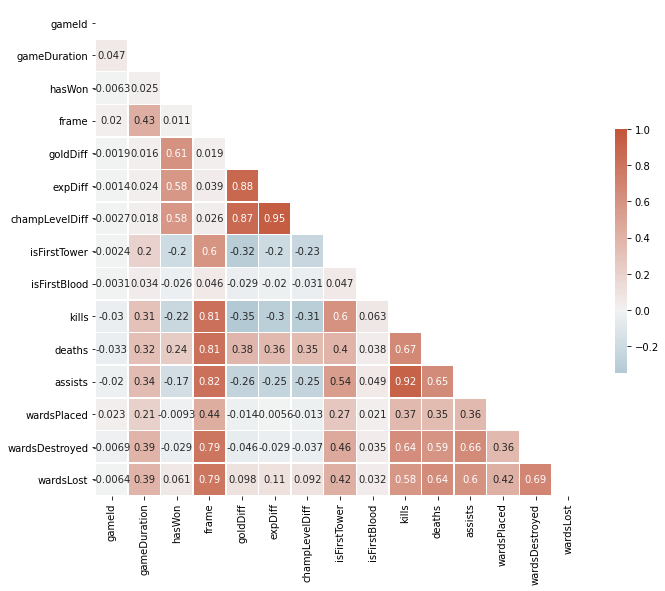

In [ ]:
selected_cols = df.columns[
           ~df.columns.str.startswith('killed') &
           ~df.columns.str.startswith('destroyed') &
           ~df.columns.str.startswith('lost')
].tolist()

# Obtém a correlação entre as coluna selecionadas
corr = df[selected_cols].corr()

# Gera uma máscara para o triângulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Define uma figura do matplotlib
f, ax = plt.subplots(figsize=(11, 9))

# Gera um colormap divergente
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Desenha um heatmap com a máscara e o correto proporção
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### Conclusões da exploração

- Variáveis `killed` e `destroyed` possuem correlação 1 com a variável espelho `lost`. 
- As variáveis com as duas maiores correlações no último gráfico são `champLevelDiff` com `expDiff` e `assists` com `kills`
- As variáveis `frame`, `isFirstTower`, `kills` e `deaths` possuem forte correlação com múltiplas variáveis do dataset como podemos ver na imagem acima.

Variáveis independentes que são altamente correlacionadas entre si não podem ser colocadas no mesmo modelo porque fornecem as mesmas informações. A matriz de correlação é usada para detectar essas variáveis.

## Preparação dos dados

 - Já removemos colunas que são preenchidas apenas com zeros
 - Vamos remover as colunas que possuem correlação alta
 - Extrair a coluna contendo o label que desejamos classificar
 - Normalizar os dados
 - Separar em treino e teste

 

In [ ]:
# Remover as colunas que começam com lost*, pois possuem correlação 1
X = df[df.columns[~df.columns.str.startswith('lost')]].copy()

In [ ]:
# Extrair label para classificação
y = X['hasWon']
X = X.drop('hasWon', axis=1)

In [ ]:
# Remover colunas com forte correlação
X = X.drop(
    ['champLevelDiff', 'frame', 'isFirstTower', 'kills', 'deaths', 'assists'],
    axis=1
)
# Remover id do jogo
X = X.drop('gameId', axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242572 entries, 0 to 242571
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   gameDuration             242572 non-null  int64
 1   goldDiff                 242572 non-null  int64
 2   expDiff                  242572 non-null  int64
 3   isFirstBlood             242572 non-null  int64
 4   killedFireDrake          242572 non-null  int64
 5   killedWaterDrake         242572 non-null  int64
 6   killedAirDrake           242572 non-null  int64
 7   killedEarthDrake         242572 non-null  int64
 8   killedElderDrake         242572 non-null  int64
 9   killedBaronNashor        242572 non-null  int64
 10  killedRiftHerald         242572 non-null  int64
 11  destroyedTopInhibitor    242572 non-null  int64
 12  destroyedMidInhibitor    242572 non-null  int64
 13  destroyedBotInhibitor    242572 non-null  int64
 14  destroyedTopNexusTurret  242572 non-

Nosso *dataset* foi reduzido para 27 colunas que utilizaremos para a classificação.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Obter para usar posteriormente
feature_list = X.columns.tolist()

X = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

print('Quantidade de dados para treino:', X_train.shape[0])
print('Quantidade de dados para teste:', X_test.shape[0])

Quantidade de dados para treino: 162523
Quantidade de dados para teste: 80049


## Classificação

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

target_names = ['perdeu', 'venceu']

In [ ]:
# Reunir conjunto de classificadores populares
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      perdeu       0.50      0.50      0.50     39766
      venceu       0.50      0.50      0.50     40283

    accuracy                           0.50     80049
   macro avg       0.50      0.50      0.50     80049
weighted avg       0.50      0.50      0.50     80049



In [ ]:
for name, clf in zip(names, classifiers):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(f'Classification Report - {name}:')
  print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report - Nearest Neighbors:
              precision    recall  f1-score   support

      perdeu       0.81      0.81      0.81     39766
      venceu       0.81      0.81      0.81     40283

    accuracy                           0.81     80049
   macro avg       0.81      0.81      0.81     80049
weighted avg       0.81      0.81      0.81     80049

Classification Report - Linear SVM:
              precision    recall  f1-score   support

      perdeu       0.80      0.78      0.79     39766
      venceu       0.79      0.80      0.80     40283

    accuracy                           0.79     80049
   macro avg       0.79      0.79      0.79     80049
weighted avg       0.79      0.79      0.79     80049

Classification Report - RBF SVM:
              precision    recall  f1-score   support

      perdeu       0.82      0.79      0.81     39766
      venceu       0.80      0.83      0.82     40283

    accuracy                           0.81     80049
   macro avg    

Dentre os classificadores acima, as maiores acurácias, mantendo alta precisão e *recall*, foram reportadas pelo *RandomForest* com 82% de acurácia e  *KNN* com 81% acurácia. 

O *RandomForest* nos fornece a lista de *features* consideradas mais importantes.

In [ ]:
rf_clf = classifiers[4]

importances = list(rf_clf.feature_importances_)

# tuplas com nome da variável e importância
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# ordenar lista pela mais importante
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

for feature, importance in feature_importances:
  print(f'{feature}: {importance}')

goldDiff: 0.28
expDiff: 0.24
gameDuration: 0.14
wardsPlaced: 0.07
wardsDestroyed: 0.06
wardsLost: 0.06
killedRiftHerald: 0.02
killedFireDrake: 0.01
killedWaterDrake: 0.01
killedAirDrake: 0.01
killedEarthDrake: 0.01
killedBaronNashor: 0.01
destroyedBotInhibitor: 0.01
destroyedBotNexusTurret: 0.01
destroyedMidInnerTurret: 0.01
destroyedBotInnerTurret: 0.01
destroyedTopOuterTurret: 0.01
destroyedMidOuterTurret: 0.01
destroyedBotOuterTurret: 0.01
isFirstBlood: 0.0
killedElderDrake: 0.0
destroyedTopInhibitor: 0.0
destroyedMidInhibitor: 0.0
destroyedTopNexusTurret: 0.0
destroyedMidNexusTurret: 0.0
destroyedBotBaseTurret: 0.0
destroyedTopInnerTurret: 0.0


In [ ]:
# Removemos as últimas 8 features por terem importância 0
important_feature_names = [feature[0] for feature in feature_importances[:-8]]
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Novo subset considerando apenas a features com importância maior que zero
important_train_features = X_train[:, important_indices]
important_test_features = X_test[:, important_indices]

In [ ]:
rf_clf.fit(important_train_features, y_train)
y_pred = rf_clf.predict(important_test_features)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      perdeu       0.82      0.83      0.82     39766
      venceu       0.83      0.82      0.82     40283

    accuracy                           0.82     80049
   macro avg       0.82      0.82      0.82     80049
weighted avg       0.82      0.82      0.82     80049



Podemos notar que a acurácia se manteve a mesma após remoção das features que não contribuíam, assim para conseguir a acurácia de 82% não é necessário ter as 27 características que selecionamos.

## Conclusões

Grande parte das colunas do conjunto de dados possue forte correlação entre si. Algumas colunas não influenciam no resultado da partida, como *gameId* e o fato de algo ser destruído. Algumas coisas que podem ser feitas:

- Busca de hiper-parâmetros
- Métodos para seleção de características
- Fazer a remoção de colunas que sejam populadas majoritariamente com o mesmo valor. Por exemplo, a coluna `killedElderDrake` possui 99% dos seus registros com o valor 0.
- Experimentar outros algoritmos de classificação

Vale notar que classificamos se um jogo foi ganho ou perdido com base em cada *frame*, podemos verificar estratégias que considerem um conjunto de *frames* para realizar a predição.

